# Relatório do Projeto: Raciocínio Espacial com Logic Tensor Networks (LTN)

## 1. Introdução à Inteligência Artificial Neuro-Simbólica (NeSy) e LTN

### Inteligência Artificial Neuro-Simbólica (NeSy)

A Inteligência Artificial Neuro-Simbólica (Neural-Symbolic AI) é um campo de pesquisa que visa integrar os dois paradigmas fundamentais da IA:

* **Redes Neurais (Conexionista):** Excelentes em aprendizado a partir de dados brutos (como imagens), generalização e robustez a ruídos.
* **Lógica Simbólica:** Excelente em raciocínio dedutivo, abstração, cumprimento de regras estritas e explicabilidade.

O objetivo de sistemas NeSy é criar modelos que aprendem com dados (percepção), mas respeitam regras lógicas e conhecimentos prévios (raciocínio), superando a "caixa preta" das redes neurais puras.

### Logic Tensor Networks (LTN)

Logic Tensor Networks (LTN) é um framework que fundamenta (*grounds*) a Lógica de Primeira Ordem em operações com tensores reais (Real Logic). No LTN:

* **Símbolos (Constantes/Variáveis):** São mapeados para tensores de dados (feature vectors).
* **Predicados (ex: `IsRed(x)`, `LeftOf(x,y)`):** São funções (redes neurais ou operações matemáticas) que retornam um grau de verdade no intervalo  (Lógica Fuzzy).
* **Conectivos () e Quantificadores ():** São implementados como operações difusas (t-normas) e agregações (média, máximo), permitindo o aprendizado via gradiente descendente (backpropagation).


## 2. O Dataset CLEVR e a Representação Simplificada

### O Dataset CLEVR Original

O CLEVR (*Compositional Language and Elementary Visual Reasoning*) é um dataset de diagnóstico para raciocínio visual. Cada cena contém objetos 3D renderizados com atributos e relacionamentos definidos:

* **Atributos:**
* **Formas:** Cubo, Esfera, Cilindro.
* **Tamanhos:** Pequeno (Small), Grande (Large).
* **Materiais:** Borracha (Rubber), Metal.
* **Cores (8):** Cinza, Azul, Marrom, Amarelo, Vermelho, Verde, Roxo, Ciano.


* **Relacionamentos:** O dataset fornece grafos de adjacência definindo relações espaciais (`left`, `right`, `front`, `behind`) entre os objetos.

### Descrição Simplificada (Simulação Feature-Vector)

Neste projeto, utilizamos uma versão simplificada do ambiente CLEVR. Em vez de processar imagens (pixels) ou utilizar todos os atributos do JSON original, extraímos vetores de características (*feature vectors*) focados em geometria plana e cores primárias.

A função de carregamento (`load_clevr_scene_from_json`) converte cada objeto da cena em um **tensor de 11 dimensões**:

1. **Posição  [Índices 0-1]:**
* As coordenadas 3D originais do CLEVR são normalizadas para o intervalo .
* Ignora-se a profundidade () e rotação, tratando o problema como um plano 2D.


2. **Cores RGB (One-Hot) [Índices 2-4]:**
* O código filtra apenas as cores primárias do dataset.
* `[1, 0, 0]` se `Red`; `[0, 1, 0]` se `Green`; `[0, 0, 1]` se `Blue`. Outras cores (ex: Ciano, Amarelo) resultam em vetor zerado (cinza/neutro).


3. **Formas Geométricas (One-Hot) [Índices 5-9]:**
* Adaptação das formas 3D do CLEVR para formas 2D equivalentes, com slots extras para formas não presentes no dataset original (para testes de robustez):
* Índice 5: **Círculo** (Mapeado de `Sphere`)
* Índice 6: **Quadrado** (Mapeado de `Cube`)
* Índice 7: **Cilindro** (Mapeado de `Cylinder`)
* Índice 8: **Cone** (Slot reservado/Vazio no CLEVR padrão)
* Índice 9: **Triângulo** (Slot reservado/Vazio no CLEVR padrão)


4. **Tamanho [Índice 10]:**
* Valor binário convertido para float:  para `small` e  para `large`.

In [1]:
!pip install ltntorch -q

In [2]:
# --- CÉLULA 1: SETUP ---
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ltn
import itertools
import json
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random

In [3]:

# Configuração de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Configurações de visualização
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

Usando dispositivo: cpu


In [4]:
# --- CARREGAMENTO DE DADOS (JSON) ---

def load_clevr_scene_from_json(json_path, scene_index=0):
    """
    Carrega uma cena específica de um arquivo JSON do CLEVR e converte
    para o formato de tensor esperado pelo modelo LTN.

    Formato do Tensor [n_objects, 11]:
    [0,1]: x, y (Normalizados 0.0 - 1.0)
    [2-4]: RGB (IsRed, IsGreen, IsBlue)
    [5-9]: Formas (Circle/Sphere, Square/Cube, Cylinder, Cone, Triangle)
    [10]: Size (0.0=Small, 1.0=Large)
    """

    with open(json_path, 'r') as f:
        data_json = json.load(f)

    if 'scenes' in data_json:
        idx = scene_index % len(data_json['scenes'])
        scene = data_json['scenes'][idx]
    else:
        scene = data_json

    objects_list = scene['objects']
    n_objects = len(objects_list)

    # Inicializa tensor zerado
    tensor_data = torch.zeros((n_objects, 11))

    for i, obj in enumerate(objects_list):
        # 1. Posição x, y (CLEVR 3d_coords geralmente varia de -3 a 3)
        # Normalizamos para 0 a 1 para funcionar bem com a Sigmoide do LTN
        # x_raw = obj['3d_coords'][0], y_raw = obj['3d_coords'][1]

        x_norm = (obj['3d_coords'][0] + 3.0) / 6.0
        y_norm = (obj['3d_coords'][1] + 3.0) / 6.0

        # Clamp para garantir que fique entre 0 e 1 mesmo se passar um pouco
        tensor_data[i, 0] = max(0.0, min(1.0, x_norm))
        tensor_data[i, 1] = max(0.0, min(1.0, y_norm))

        # 2. Cores (Mapeamento String -> One Hot)
        # O modelo atual suporta Red, Green, Blue. Outras cores (Cyan, Yellow, etc) ficarão zeradas.
        color = obj.get('color', '').lower()
        if color == 'red':   tensor_data[i, 2] = 1.0
        elif color == 'green': tensor_data[i, 3] = 1.0
        elif color == 'blue':  tensor_data[i, 4] = 1.0

        # 3. Formas (Mapeamento String -> One Hot)
        # CLEVR Real: Sphere, Cube, Cylinder
        # Modelo LTN: Circle(5), Square(6), Cylinder(7), Cone(8), Triangle(9)
        shape = obj.get('shape', '').lower()
        if shape == 'sphere':    tensor_data[i, 5] = 1.0
        elif shape == 'cube':      tensor_data[i, 6] = 1.0
        elif shape == 'cylinder':  tensor_data[i, 7] = 1.0
        # Cone e Triangle ficarão 0 pois não existem no CLEVR

        # 4. Tamanho
        size = obj.get('size', '').lower()
        if size == 'large':
            tensor_data[i, 10] = 1.0 # 1.0 para Grande
        else:
            tensor_data[i, 10] = 0.0 # 0.0 para Small

    return tensor_data.to(device)

print("Carregador de JSON CLEVR definido.")

Carregador de JSON CLEVR definido.


Visualizando Cena 10 do arquivo CLEVR_val_scenes.json
Número de objetos: 5


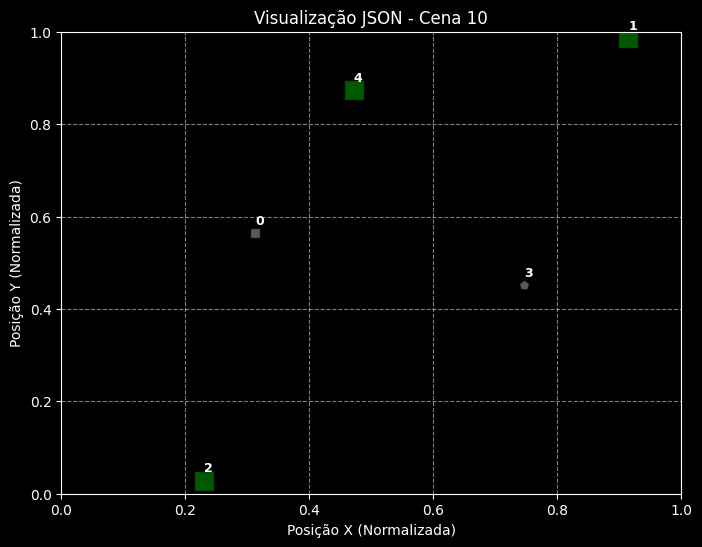

In [5]:
# --- VISUALIZAÇÃO DE DADOS (JSON) ---

import matplotlib.pyplot as plt

# Caminho do arquivo
JSON_FILE_PATH = "CLEVR_val_scenes.json"

def plot_scenario(tensor_data, title="Cenário CLEVR Real"):
    """
    Plota o cenário baseado no tensor [N, 11].
    Nota: Cores fora de Red/Green/Blue aparecerão como Cinza.
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    data = tensor_data.cpu().numpy()

    # Se não houver objetos
    if len(data) == 0:
        ax.text(0.5, 0.5, "Cena Vazia", ha='center', va='center', fontsize=12)
        plt.show()
        return

    for i in range(len(data)):
        vec = data[i]
        x, y = vec[0], vec[1]

        # Decodifica Cor (Se não for R, G ou B, assume cinza/outra)
        c = 'gray' # Cor padrão para Cyan, Yellow, Purple, Gray, etc.
        if vec[2] > 0.5: c = 'red'
        elif vec[3] > 0.5: c = 'green'
        elif vec[4] > 0.5: c = 'blue'

        # Decodifica Forma
        # Mapeamento do Loader: 5=Sphere, 6=Cube, 7=Cylinder
        m = 'o'
        if vec[5] > 0.5: m = 'o'   # Sphere (Círculo)
        elif vec[6] > 0.5: m = 's' # Cube (Quadrado)
        elif vec[7] > 0.5: m = 'p' # Cylinder (Pentágono como aproximação)
        elif vec[8] > 0.5: m = '^' # Cone (Se houver)
        elif vec[9] > 0.5: m = 'v' # Triangle (Se houver)

        # Decodifica Tamanho (1.0 = Large, 0.0 = Small)
        size = 200 if vec[10] > 0.5 else 60

        ax.scatter(x, y, c=c, marker=m, s=size, edgecolors='black', alpha=0.7)
        ax.text(x, y+0.02, str(i), fontsize=9, fontweight='bold')

    ax.set_xlim(0, 1); ax.set_ylim(0, 1)
    ax.set_xlabel("Posição X (Normalizada)"); ax.set_ylabel("Posição Y (Normalizada)")
    ax.set_title(title)
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# --- TESTE COM DADOS ---
try:
    # Escolha o índice da cena que deseja visualizar (0, 1, 2...)
    SCENE_INDEX = 10

    data_real = load_clevr_scene_from_json(JSON_FILE_PATH, scene_index=SCENE_INDEX)

    print(f"Visualizando Cena {SCENE_INDEX} do arquivo {JSON_FILE_PATH}")
    print(f"Número de objetos: {len(data_real)}")

    plot_scenario(data_real, title=f"Visualização JSON - Cena {SCENE_INDEX}")

except FileNotFoundError:
    print(f"Erro: Arquivo '{JSON_FILE_PATH}' não encontrado. Faça upload no Colab.")
except NameError:
    print("Erro: A função 'load_clevr_scene_from_json' não foi definida. Rode a Célula 2 modificada antes.")
except Exception as e:
    print(f"Erro ao plotar: {e}")

In [6]:
# --- PREDICADOS (MODELO) ---

class ModelSpatial(torch.nn.Module):
    def __init__(self, predicate_type, sensitivity=10.0):
        super(ModelSpatial, self).__init__()
        self.sigma = sensitivity
        self.predicate_type = predicate_type

    def forward(self, *args):
        obj1 = args[0]
        if len(args) > 1:
            obj2 = args[1]

        if self.predicate_type == "IsCircle": return obj1[:, 5]
        if self.predicate_type == "IsSquare": return obj1[:, 6]
        if self.predicate_type == "IsCylinder": return obj1[:, 7]
        if self.predicate_type == "IsCone": return obj1[:, 8]
        if self.predicate_type == "IsTriangle": return obj1[:, 9]

        if self.predicate_type == "IsRed": return obj1[:, 2]
        if self.predicate_type == "IsGreen": return obj1[:, 3]
        if self.predicate_type == "IsBlue": return obj1[:, 4]

        if self.predicate_type == "IsSmall": return 1.0 - obj1[:, 10]
        if self.predicate_type == "IsBig": return obj1[:, 10]

        if self.predicate_type == "LeftOf":
            return torch.sigmoid((obj2[:, 0] - obj1[:, 0]) * self.sigma)

        if self.predicate_type == "RightOf":
            return torch.sigmoid((obj1[:, 0] - obj2[:, 0]) * self.sigma)

        if self.predicate_type == "CloseTo":
            dist_sq = torch.sum((obj1[:,:2] - obj2[:,:2])**2, dim=1)
            return torch.exp(-2.0 * dist_sq)

        if self.predicate_type == "SameSize":
            return 1.0 - torch.abs(obj1[:, 10] - obj2[:, 10])

        if self.predicate_type == "Below":
            return torch.sigmoid((obj2[:, 1] - obj1[:, 1]) * self.sigma)

        if self.predicate_type == "Above":
            return torch.sigmoid((obj1[:, 1] - obj2[:, 1]) * self.sigma)

        if self.predicate_type == "CanStack":
            is_cone = obj2[:, 8]
            is_tri = obj2[:, 9]
            return 1.0 - torch.max(is_cone, is_tri)

        return torch.zeros(len(obj1)).to(device)

# Instanciando os Predicados
IsCircle = ltn.Predicate(ModelSpatial("IsCircle"))
IsSquare = ltn.Predicate(ModelSpatial("IsSquare"))
IsCylinder = ltn.Predicate(ModelSpatial("IsCylinder"))
IsCone = ltn.Predicate(ModelSpatial("IsCone"))
IsTriangle = ltn.Predicate(ModelSpatial("IsTriangle"))

IsRed = ltn.Predicate(ModelSpatial("IsRed"))
IsGreen = ltn.Predicate(ModelSpatial("IsGreen"))
IsBlue = ltn.Predicate(ModelSpatial("IsBlue"))

IsSmall = ltn.Predicate(ModelSpatial("IsSmall"))
IsBig = ltn.Predicate(ModelSpatial("IsBig"))

LeftOf = ltn.Predicate(ModelSpatial("LeftOf"))
RightOf = ltn.Predicate(ModelSpatial("RightOf"))
CloseTo = ltn.Predicate(ModelSpatial("CloseTo"))
SameSize = ltn.Predicate(ModelSpatial("SameSize"))

Below = ltn.Predicate(ModelSpatial("Below"))
Above = ltn.Predicate(ModelSpatial("Above"))
CanStack = ltn.Predicate(ModelSpatial("CanStack"))

print("Predicados definidos. ")

Predicados definidos. 


In [7]:
# --- OPERADORES E FÓRMULAS ---

# Operadores LTN (Lógica Fuzzy)
Not = ltn.Connective(ltn.fuzzy_ops.NotStandard())
And = ltn.Connective(ltn.fuzzy_ops.AndProd())
Or = ltn.Connective(ltn.fuzzy_ops.OrProbSum())
Implies = ltn.Connective(ltn.fuzzy_ops.ImpliesReichenbach())
Equiv = ltn.Connective(ltn.fuzzy_ops.Equiv(ltn.fuzzy_ops.AndProd(), ltn.fuzzy_ops.ImpliesReichenbach()))

# Quantificadores (p=2 para média quadrática)
Forall = ltn.Quantifier(ltn.fuzzy_ops.AggregPMeanError(p=2), quantifier="f")
Exists = ltn.Quantifier(ltn.fuzzy_ops.AggregPMean(p=2), quantifier="e")

# --- FÓRMULA INBETWEEN ---
# x está entre y e z (horizontalmente)
def InBetween(x, y, z):
    cond1 = And(LeftOf(y, x), RightOf(z, x))
    cond2 = And(LeftOf(z, x), RightOf(y, x))
    return Or(cond1, cond2)

print("Operadores e Fórmulas configurados.")

Operadores e Fórmulas configurados.


In [8]:
# --- LOOP DE EXECUÇÃO COM DADOS  ---

metrics_history = []
JSON_FILE_PATH = "CLEVR_val_scenes.json"
SATISFACTION_THRESHOLD = 0.6

print(f"{'Cena (Idx)':<10} | {'Regra/Query':<40} | {'Sat (0-1)':<10}")
print("-" * 65)

try:
    with open(JSON_FILE_PATH, 'r') as f:
        full_json = json.load(f)
        if isinstance(full_json, dict) and 'scenes' in full_json:
            total_scenes = len(full_json['scenes'])
        else:
            total_scenes = len(full_json)

    print(f"Total de cenas no arquivo: {total_scenes}")
    num_runs = 5
    if total_scenes < num_runs:
        print(f"Aviso: O arquivo tem apenas {total_scenes} cenas. Rodando todas.")
        random_indices = range(total_scenes)
    else:
        random_indices = random.sample(range(total_scenes), num_runs)

    print(f"Índices sorteados: {random_indices}")
    print("-" * 65)

except FileNotFoundError:
    print(f"ERRO: O arquivo '{JSON_FILE_PATH}' não foi encontrado.")
    random_indices = []
except Exception as e:
    print(f"ERRO ao abrir o JSON: {e}")
    random_indices = []

for scene_i in random_indices:

    try:
        data = load_clevr_scene_from_json(JSON_FILE_PATH, scene_index=scene_i)

        if data.shape[0] == 0:
            print(f"{scene_i:<10} | {'[SKIPPED] Cena vazia':<40} | 0.0000")
            continue

    except Exception as e:
        print(f"ERRO ao ler cena {scene_i}: {e}")
        continue

    x = ltn.Variable("x", data)
    y = ltn.Variable("y", data)
    z = ltn.Variable("z", data)
    kb = {}

    # --- AXIOMAS DE FORMA ---
    kb['3.1.3_Unique'] = Forall(x, Not(And(IsCircle(x), IsSquare(x))))
    kb['3.1.3_Cover'] = Forall(x, Or(IsCircle(x), Or(IsSquare(x), Or(IsCylinder(x), Or(IsCone(x), IsTriangle(x))))))

    # --- AXIOMAS ESPACIAIS ---
    kb['3.2.2_Irreflex'] = Forall(x, Not(LeftOf(x, x)))
    kb['3.2.2_Asymm'] = Forall([x,y], Implies(LeftOf(x, y), Not(LeftOf(y, x))))
    kb['3.2.2_Inverse'] = Forall([x,y], Equiv(LeftOf(x, y), RightOf(y, x)))
    kb['3.2.2_Transit'] = Forall([x,y,z], Implies(And(LeftOf(x, y), LeftOf(y, z)), LeftOf(x, z)))

    # --- RACIOCÍNIO HORIZONTAL ---
    kb['3.2.3_LastLeft'] = Exists(x, Forall(y, Implies(Not(CloseTo(x,y)), LeftOf(x,y))))
    kb['3.2.3_LastRight'] = Exists(x, Forall(y, Implies(Not(CloseTo(x,y)), RightOf(x,y))))

    # --- (Opcionais) ---
    kb['3.2.3_Sq_Ci_Constraint'] = Forall([x,y], Implies(And(IsSquare(x), IsCircle(y)), RightOf(x, y)))
    kb['3.2.3_Exist_left_Sq'] = Exists(x, Forall(y, Implies(IsSquare(y), LeftOf(x, y))))


    # --- RACIOCÍNIO VERTICAL ---
    kb['Task3_Vert_Inv'] = Forall([x,y], Equiv(Below(x,y), Above(y,x)))
    kb['Task3_Vert_Trans'] = Forall([x,y,z], Implies(And(Below(x,y), Below(y,z)), Below(x,z)))
    kb['Task3_StackRule'] = Forall([x,y], Implies(CanStack(x,y), Not(Or(IsCone(y), IsTriangle(y)))))

    # --- RACIOCÍNIO COMPOSTO ---
    kb['3.3.1_ComplexQuery'] = Exists(x, And(IsSmall(x),
                                         And(Exists(y, And(IsCylinder(y), Below(x,y))),
                                             Exists(z, And(IsSquare(z), LeftOf(x,z))))))

    kb['3.3.2_ConeInBetween'] = Exists([x,y,z], And(And(IsCone(x), IsGreen(x)), InBetween(x,y,z)))
    kb['3.3.3_ProxRule'] = Forall([x,y], Implies(And(And(IsTriangle(x), IsTriangle(y)), CloseTo(x,y)), SameSize(x,y)))

    # Avaliação
    run_results = {'Scene_Index': scene_i}
    for name, formula in kb.items():
        sat = formula.value.item()
        run_results[name] = sat
        print(f"{scene_i:<10} | {name:<40} | {sat:.4f}")

    metrics_history.append(run_results)
    print("-" * 65)

# Gera o DataFrame Final
if len(metrics_history) > 0:
    df_final = pd.DataFrame(metrics_history)
    print("\nDataFrame df_final gerado com sucesso.")
else:
    print("\nNenhuma métrica gerada. Verifique o arquivo JSON.")

Cena (Idx) | Regra/Query                              | Sat (0-1) 
-----------------------------------------------------------------
Total de cenas no arquivo: 15000
Índices sorteados: [9876, 1765, 4414, 835, 9215]
-----------------------------------------------------------------
9876       | 3.1.3_Unique                             | 0.9998
9876       | 3.1.3_Cover                              | 0.9997
9876       | 3.2.2_Irreflex                           | 0.4999
9876       | 3.2.2_Asymm                              | 0.8666
9876       | 3.2.2_Inverse                            | 0.7640
9876       | 3.2.2_Transit                            | 0.9624
9876       | 3.2.3_LastLeft                           | 0.6855
9876       | 3.2.3_LastRight                          | 0.7140
9876       | 3.2.3_Sq_Ci_Constraint                   | 0.9504
9876       | 3.2.3_Exist_left_Sq                      | 0.8672
9876       | Task3_Vert_Inv                           | 0.7758
9876       | Task3_Vert_Tr

In [9]:
# --- MÉTRICAS FORMAIS ---
# Esta célula calcula: SatAgg, Acurácia, Precisão, Recall e F1-Score
# Assumimos ground truth semântico: todas as fórmulas DEVEM ser verdadeiras
# Avaliação semântica em LTN com métricas clássicas como proxy


SAT_THRESHOLD = 0.6     # decisão do modelo
TOP_PERC = 0.3         # ground truth semântico

metrics_per_formula = []

for formula in df_final.columns:
    if formula == "Run":
        continue

    sats = df_final[formula].values

    # 1. Ground Truth SEMÂNTICO (ranking relativo)
    high_thr = np.quantile(sats, 1 - TOP_PERC)

    # Ground truth: fórmula é "boa" se costuma estar no topo
    y_true = [1 if s >= high_thr else 0 for s in sats]

    # 2. Predição do MODELO (threshold absoluto)
    y_pred = [1 if s >= SAT_THRESHOLD else 0 for s in sats]

    # 3. Métricas
    accuracy  = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall    = recall_score(y_true, y_pred, zero_division=0)
    f1        = f1_score(y_true, y_pred, zero_division=0)

    # 4. SatAgg
    sat_agg = np.mean(sats)

    metrics_per_formula.append({
        "Formula": formula,
        "SatAgg": sat_agg,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    })

df_metrics = pd.DataFrame(metrics_per_formula)

print("\n=== MÉTRICAS SEMÂNTICAS ===")
display(df_metrics)

df_metrics.to_csv("metricas_ltn.csv", index=False)
print("\nArquivo 'metricas_ltn.csv' salvo.")


=== MÉTRICAS SEMÂNTICAS ===


,Formula,SatAgg,Accuracy,Precision,Recall,F1
0,Scene_Index,5221.000000,0.4,0.4,1.0,0.571429
1,3.1.3_Unique,0.999822,0.4,0.4,1.0,0.571429
2,3.1.3_Cover,0.999702,0.4,0.4,1.0,0.571429
3,3.2.2_Irreflex,0.499950,0.0,0.0,0.0,0.000000
4,3.2.2_Asymm,0.865051,0.4,0.4,1.0,0.571429
5,3.2.2_Inverse,0.760475,0.4,0.4,1.0,0.571429
6,3.2.2_Transit,0.960890,0.4,0.4,1.0,0.571429
7,3.2.3_LastLeft,0.724015,0.4,0.4,1.0,0.571429
8,3.2.3_LastRight,0.725455,0.4,0.4,1.0,0.571429
9,3.2.3_Sq_Ci_Constraint,0.867406,0.4,0.4,1.0,0.571429



Arquivo 'metricas_ltn.csv' salvo.
